In [1]:
SEED = 42
QUICK_DEBUG = False
MEDIUM_DEBUG = True

In [2]:
import copy
import os
import sys
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap
import torch
import yaml
from custom_dataset import collate_fn
from final_pipeline import ModelWrapper, get_data, get_loss_fn, set_seeds, setup_device
from full_pipeline import find_project_root
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from training import validation_loop
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from explain_model_helpers import ShapModel, get_config, get_patient_predictions, get_pred_threshold, patient_heatmap, global_heatmap, global_importance_plot


/Users/aidend/Developer/ds_uni/dl-sepsis-prediction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


feature importance, clipping, averaging

In [3]:
set_seeds()

In [4]:
project_root = find_project_root()
results_name = "medium_model_no_sampling"
config = get_config(project_root, results_name)

device = setup_device()
train_data = get_data(config, "train")
val_data = get_data(config, "val")

test_data = get_data(config, "test")
in_dim = train_data.X.shape[1]

model = ModelWrapper(config, device, in_dim)
model.load_saved_weights()

shap_model = ShapModel(model.model, train_data, device, pad_value=0.0)
shap_vals = shap_model.get_shap_values(test_data)  # (64, 400, 107)
# print shape of shap_vals
print("shap_vals shape: ", shap_vals.shape)

# Get feature names early so they can be used throughout
feature_names = train_data.X.columns.tolist()  # list of feature names

pred_threshold = get_pred_threshold(model, val_data, device, config)
print(f"Prediction threshold: {pred_threshold}")

time_index = np.arange(shap_vals.shape[1])

# Calculate global importance for other visualizations but not for patient heatmaps
abs_vals = np.abs(shap_vals)
top_10_features = np.argsort(-abs_vals.mean(axis=(0, 1)))[:10]
top_10_feature_names = np.array(feature_names)[top_10_features]
top_10_abs_vals = np.abs(shap_vals[:, :, top_10_features])

patient_ids, y_trues, y_preds, y_probs = get_patient_predictions(
    model, test_data, device, pred_threshold
)

Using MPS device


/Users/aidend/Developer/ds_uni/dl-sepsis-prediction/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/Users/aidend/Developer/ds_uni/dl-sepsis-prediction/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower th

shap_vals shape:  (128, 400, 107)
Pos weight: 12.77
Prediction threshold: 0.9500000000000001


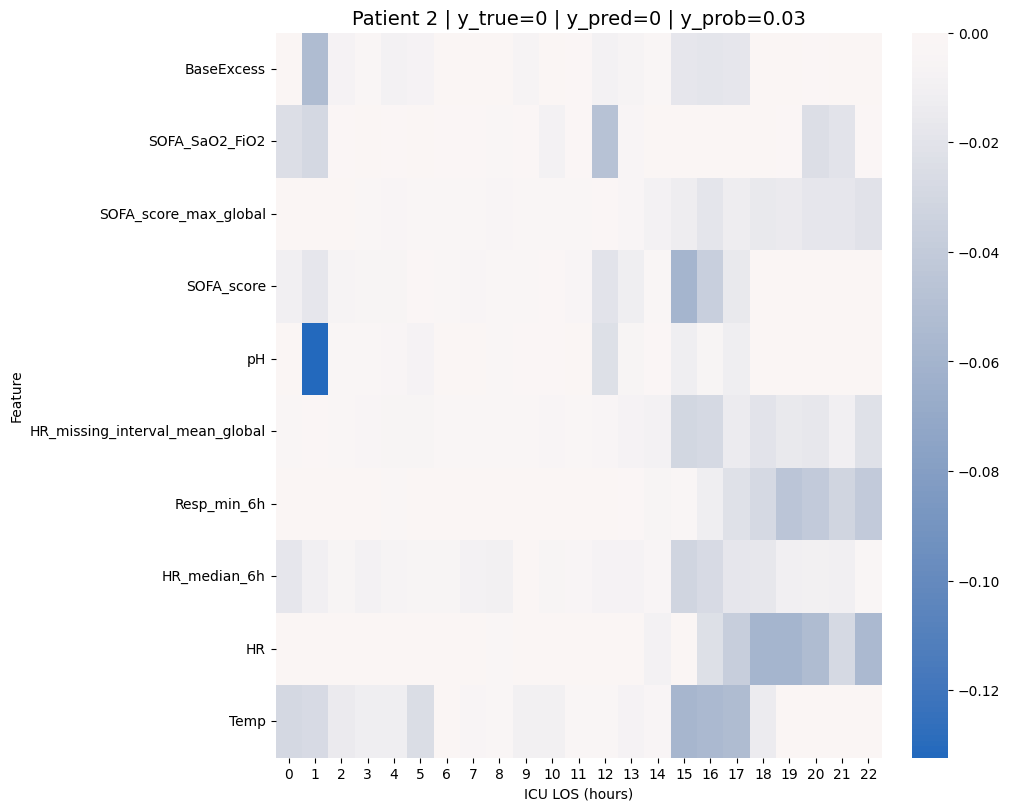

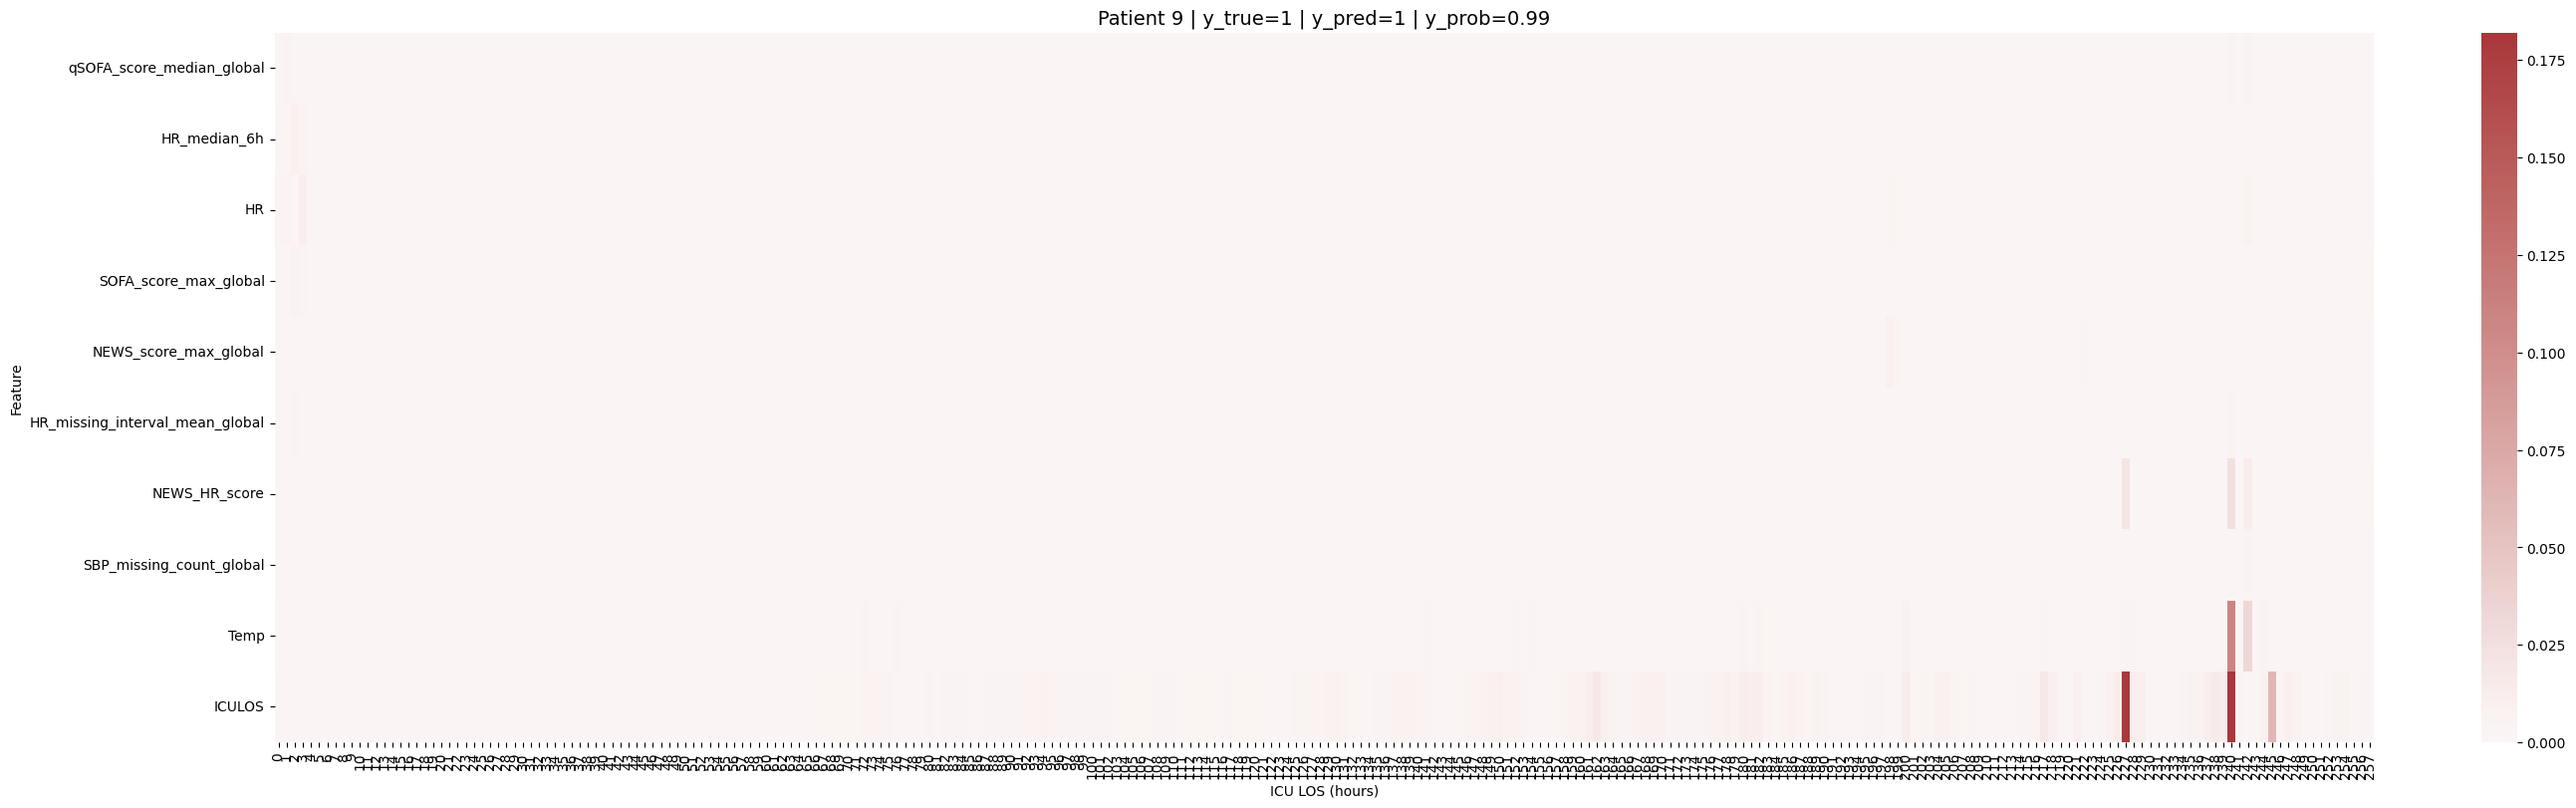

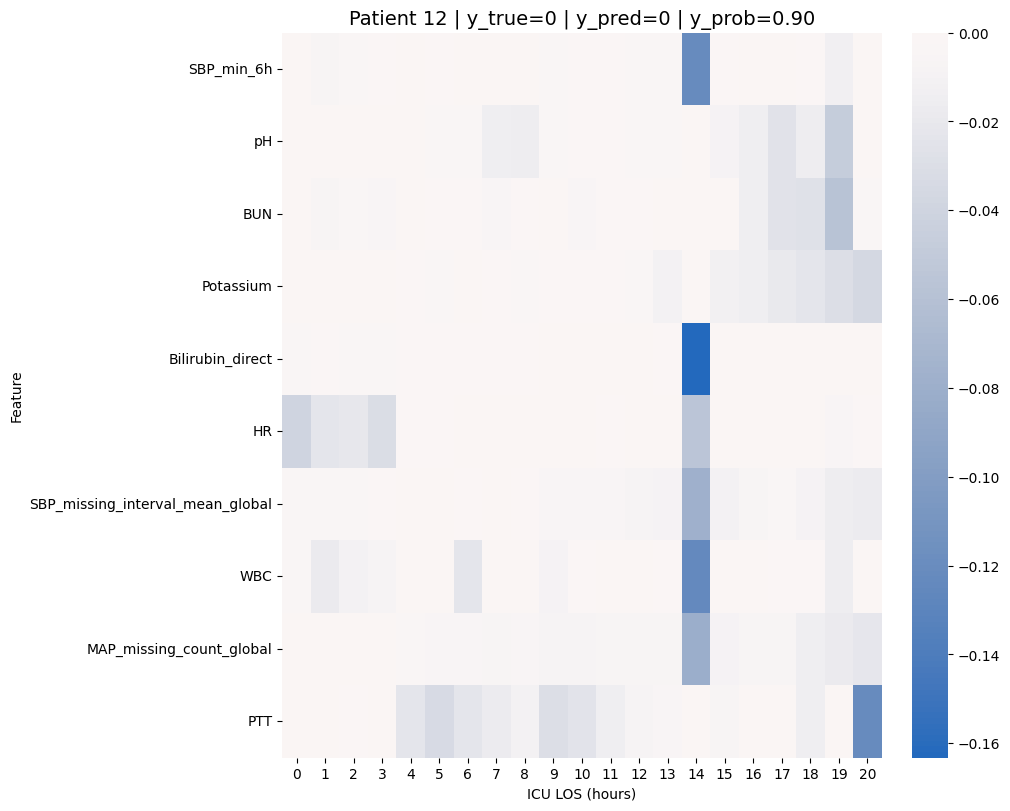

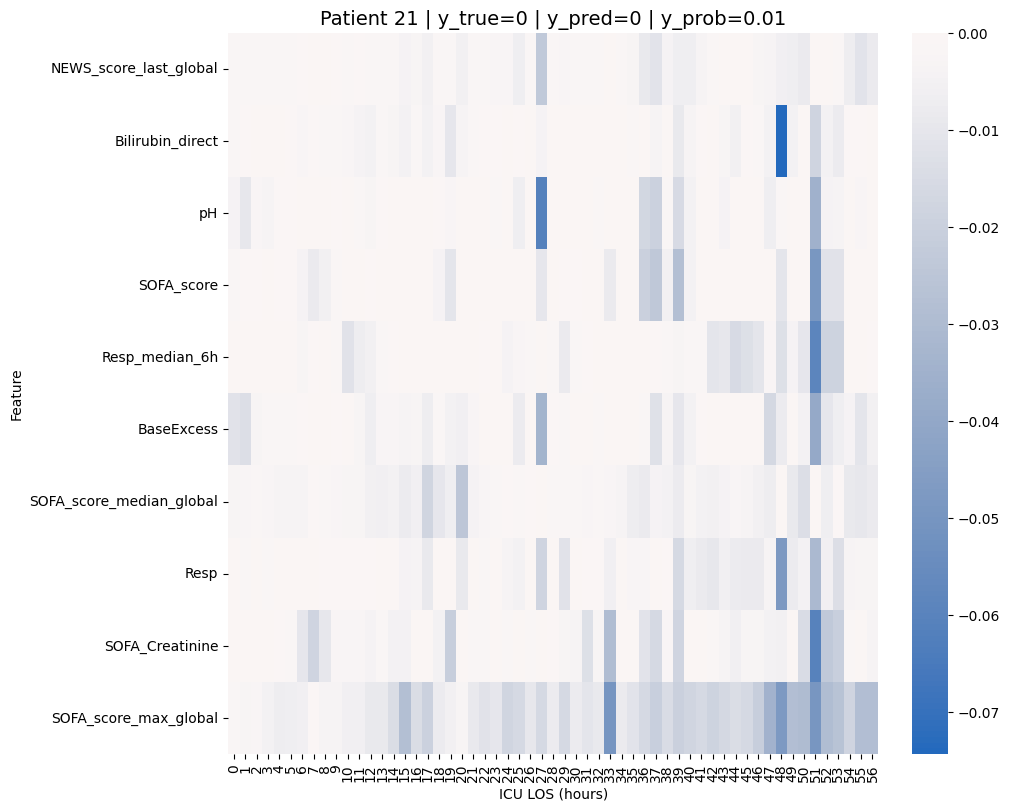

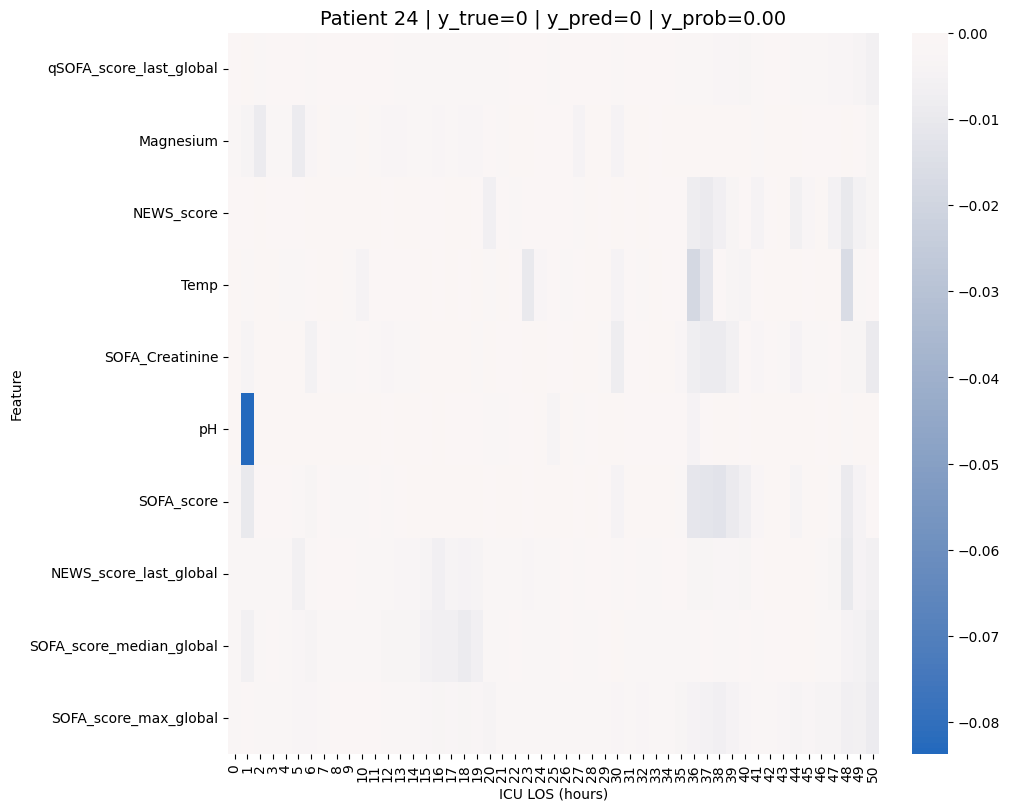

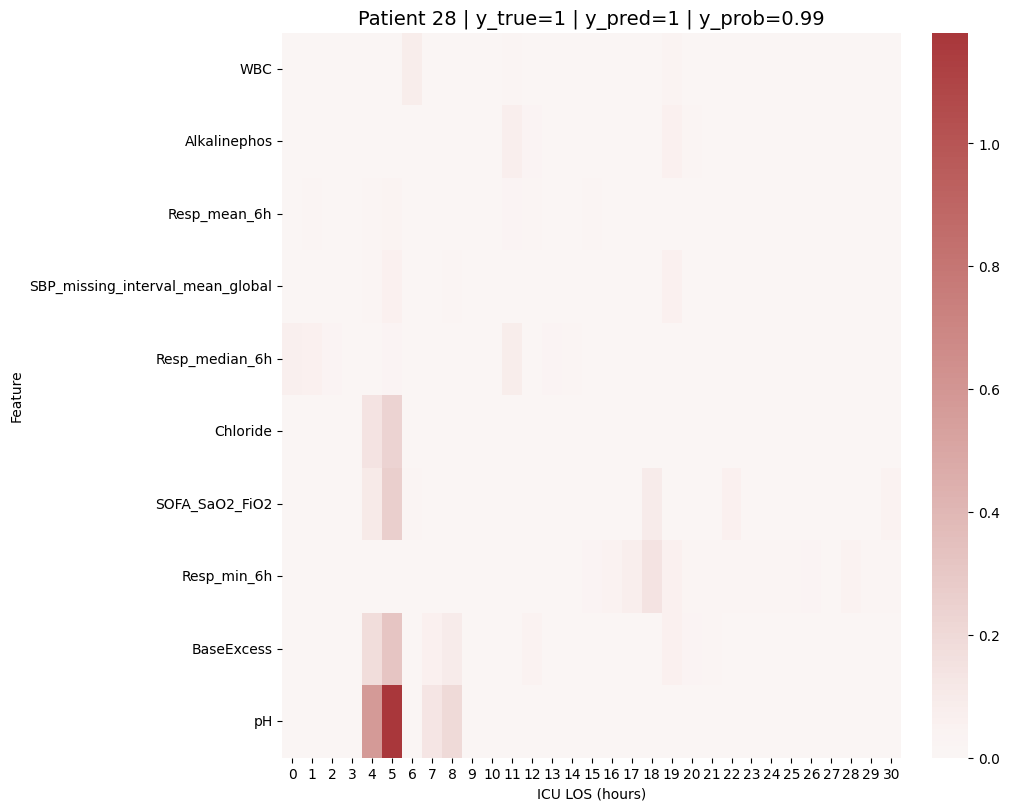

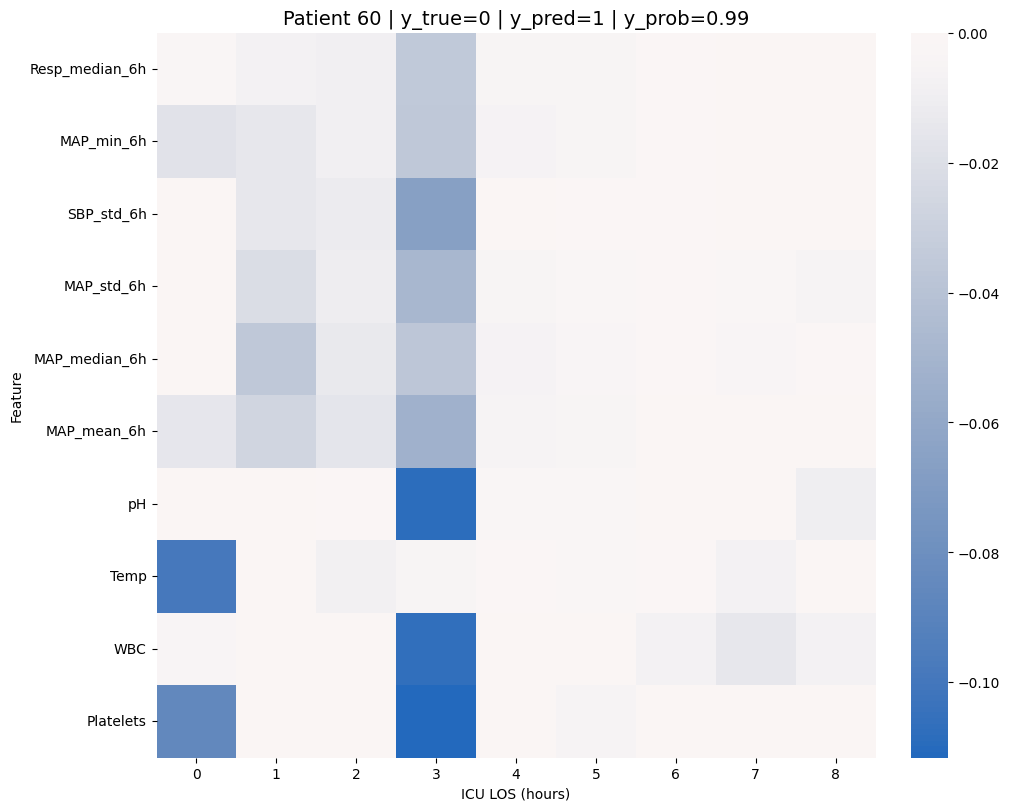

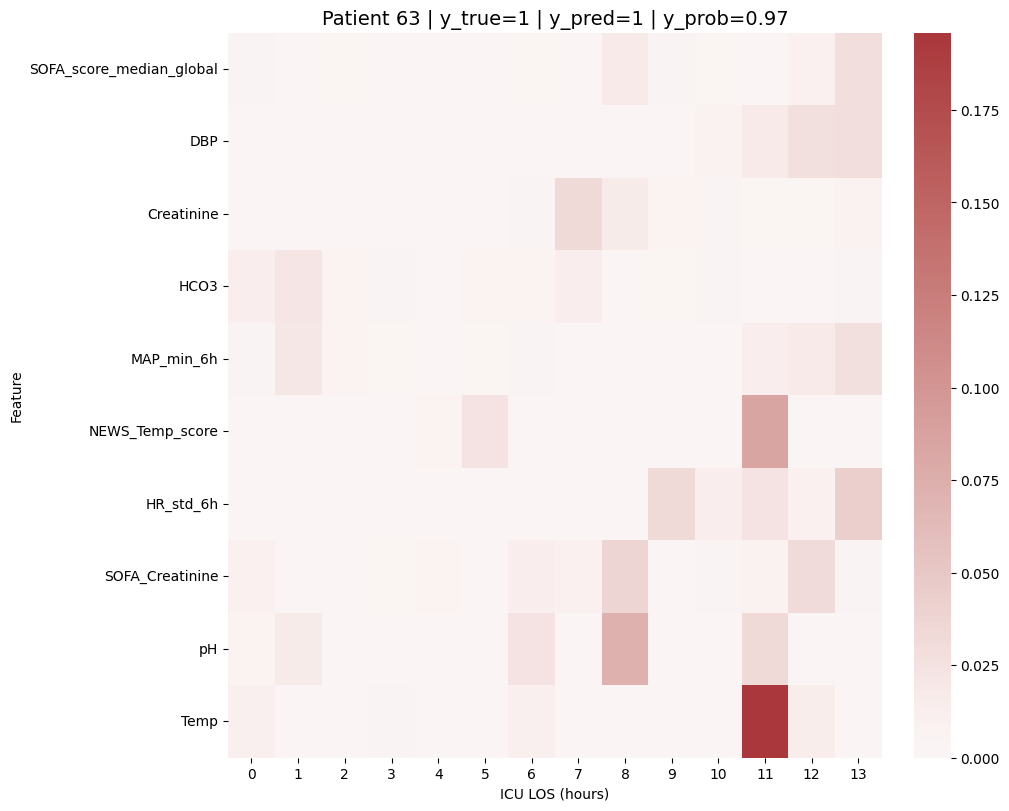

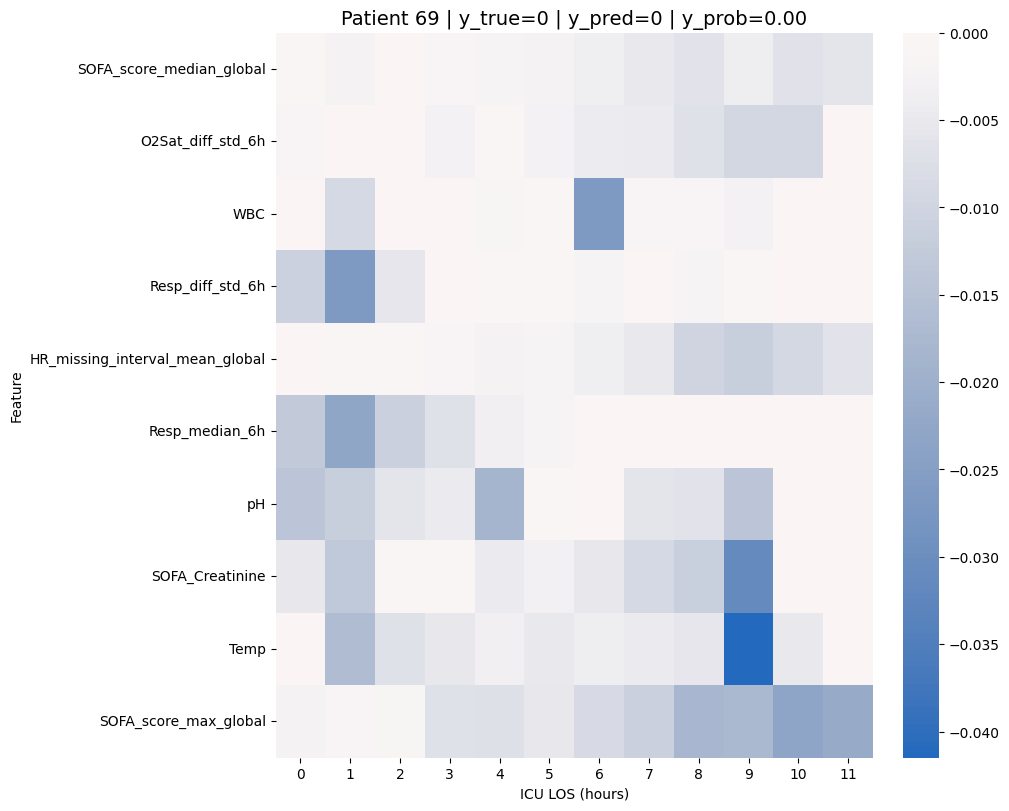

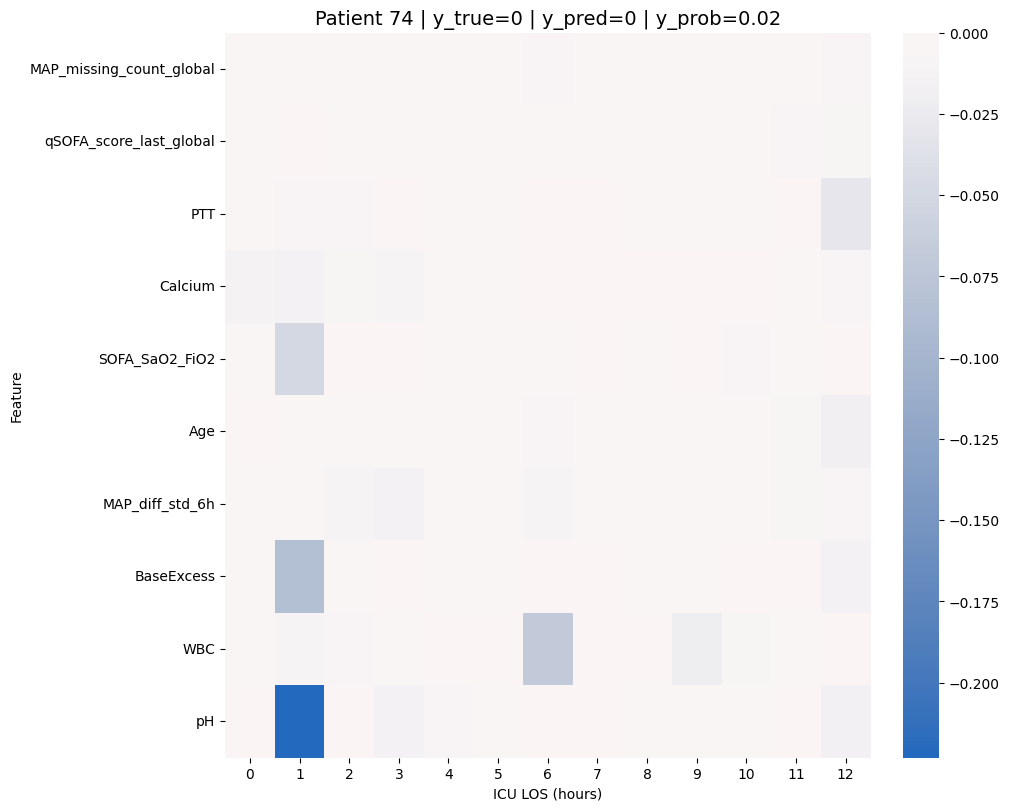

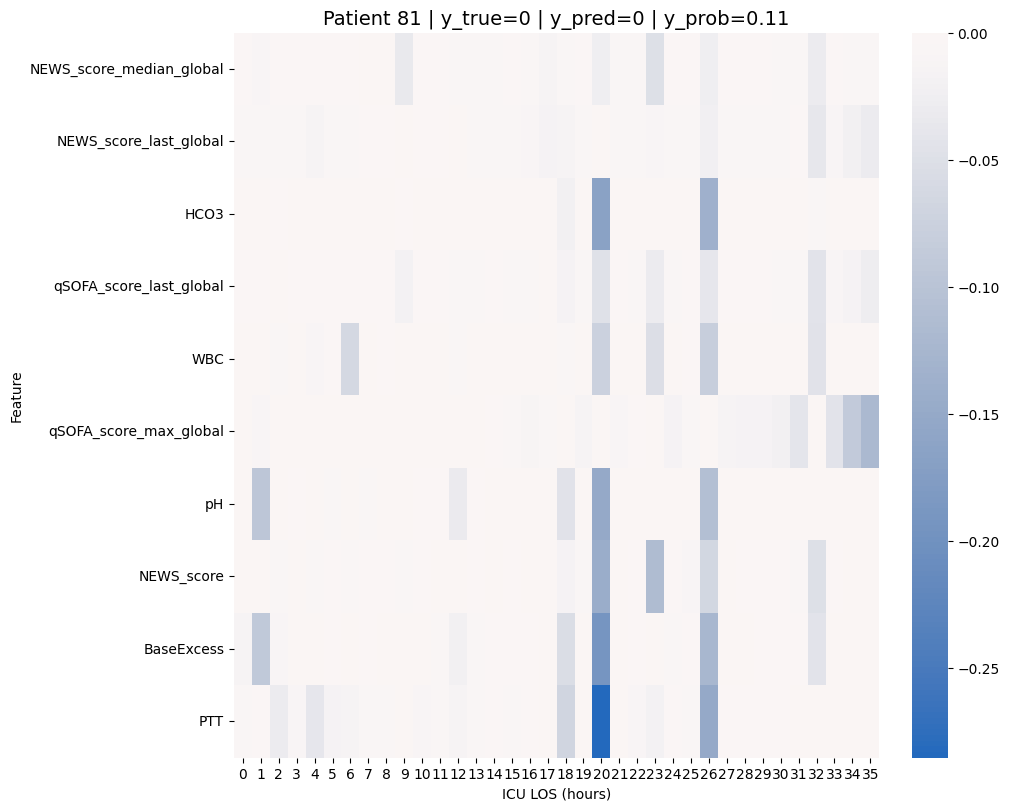

In [5]:
i = 0
for idx, (patient_id, y_true, y_pred, y_prob) in enumerate(
    zip(patient_ids, y_trues, y_preds, y_probs)
):
    patient_heatmap(
        shap_vals,  # Pass full SHAP values array
        feature_names,  # Pass all feature names
        time_index,
        idx,
        patient_id,
        y_true,
        y_pred,
        y_prob,
    )
    i += 1
    if i > 10:
        break

In [10]:
from explain_model_helpers import global_heatmap, global_importance_plot, masked_average, strip_padding, logger, CONFIG

In [37]:

def global_importance_plot(
    shap_vals: np.ndarray,
    feature_names,
    time_index,
    target: int,
    y_preds,
    *,
    show: bool = True,
    clipping_first: bool = True,
    clipping_last: bool = True,
):
    """Bar plot with *global* feature importance for predicted class ``target``."""

    max_idx = len(shap_vals) - 1
    target_indices = np.where(y_preds == target)[0]
    target_indices = target_indices[target_indices <= max_idx]
    if clipping_first:
        print("clipping first")
        target_shap_vals = np.clip(
            copy.deepcopy(shap_vals[target_indices]),
            a_min=0 if target == 1 else None,
            a_max=0 if target == 0 else None,
        )
    else:
        target_shap_vals = copy.deepcopy(shap_vals[target_indices])

    logger.debug("Aggregating %d patient explanations", len(target_indices))

    feature_averages = []
    for patient_shap in target_shap_vals:
        _, valid_patient_data = strip_padding(patient_shap, time_index)
        feature_averages.append(valid_patient_data.mean(axis=0))

    global_feature_importance = np.array(feature_averages).mean(axis=0)
    
    if clipping_last:
        print("clipping last")
        global_feature_importance = np.clip(global_feature_importance, a_min=0 if target == 1 else None, a_max=0 if target == 0 else None)

    top_features = np.argsort(np.abs(global_feature_importance))[
        -CONFIG.top_k_features :
    ]
    top_feature_names = np.array(feature_names)[top_features]

    fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

    cmap = cm.get_cmap("coolwarm")
    color = cmap(0.9) if target == 1 else cmap(0.1)

    ax.barh(top_feature_names, global_feature_importance[top_features], color=color)
    ax.set_title(f"Global Feature Importance for Class {target}")
    ax.set_xlabel("Importance")
    ax.set_ylabel("Feature")

    if show:
        plt.show()

    return fig, top_features[::-1]

In [25]:

def global_heatmap(
    shap_vals: np.ndarray,
    feature_names,
    time_index,
    target: int,
    y_preds,
    top_features: list[int] | np.ndarray | None = None,
    *,
    only_target_relevant: bool = True,
    window_size: int | None = None,
    show: bool = True,
):
    """Global heat-map of SHAP values for *predicted* class ``target``."""

    window_size = window_size or CONFIG.window_size

    shap_vals = copy.deepcopy(shap_vals)
    max_idx = len(shap_vals) - 1

    target_indices = np.where(y_preds == target)[0]
    target_indices = target_indices[target_indices <= max_idx]

    if len(target_indices) == 0:
        logger.warning("No patients were predicted as class %s", target)
        return None

    target_shap_vals = copy.deepcopy(shap_vals[target_indices])

    if only_target_relevant:
        target_shap_vals = np.clip(
            target_shap_vals,
            a_min=0 if target == 1 else None,
            a_max=0 if target == 0 else None,
        )

    mean_shap_vals = masked_average(target_shap_vals)  # (T, F)
    time_importance = np.abs(mean_shap_vals).mean(axis=1)  # (T,)

    # ------------------------------------------------------------------
    # Simpler behaviour: always show the *first* ``window_size`` timesteps.
    # ------------------------------------------------------------------
    window_start = 0
    window_end = int(min(window_size, len(time_importance)))

    logger.info(
        "Using first %d timesteps (0 – %d)", window_end - window_start, window_end
    )

    window_time_index = time_index[window_start:window_end]
    window_patient_shap_vals = target_shap_vals[:, window_start:window_end, :]
    average_shap_vals = masked_average(window_patient_shap_vals)  # (T_window, F)

    top_feature_names = np.array(feature_names)[top_features]

    # Plot --------------------------------------------------------------------
    fig, ax = plt.subplots(
        figsize=(max(10, len(window_time_index) * 0.1), 8),
        constrained_layout=True,
    )
    sns.heatmap(
        average_shap_vals[:, top_features].T,
        cmap="vlag",
        center=0,
        yticklabels=top_feature_names,
        xticklabels=window_time_index,
        ax=ax,
    )
    ax.set_title(
        (
            f"Global SHAP for class {target} – top {window_size}-hr window "
            f"(n={len(target_indices)})"
        ),
        fontsize=14,
    )
    ax.set_xlabel("ICU LOS (hours)")
    ax.set_ylabel("Feature")

    if show:
        plt.show()
    return fig


clipping last


/var/folders/s0/ldb10jg949ndmfwfkbsz5x480000gn/T/ipykernel_58790/2714719615.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


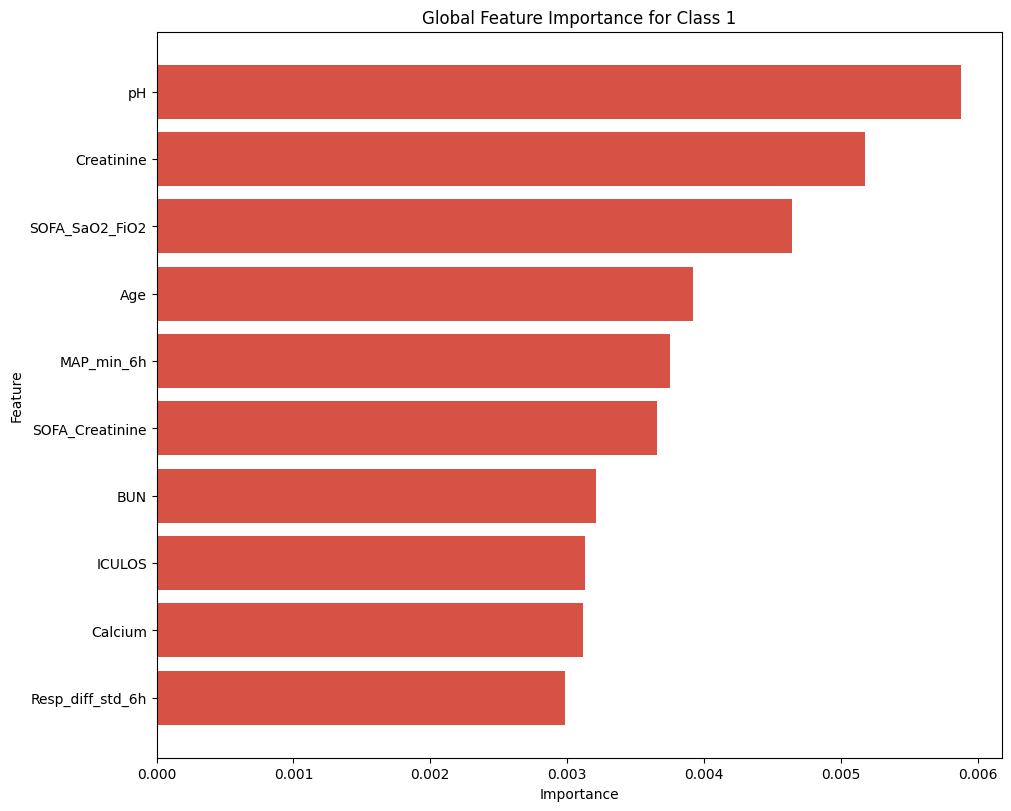

INFO | explain_model_helpers | Using first 30 timesteps (0 – 30)


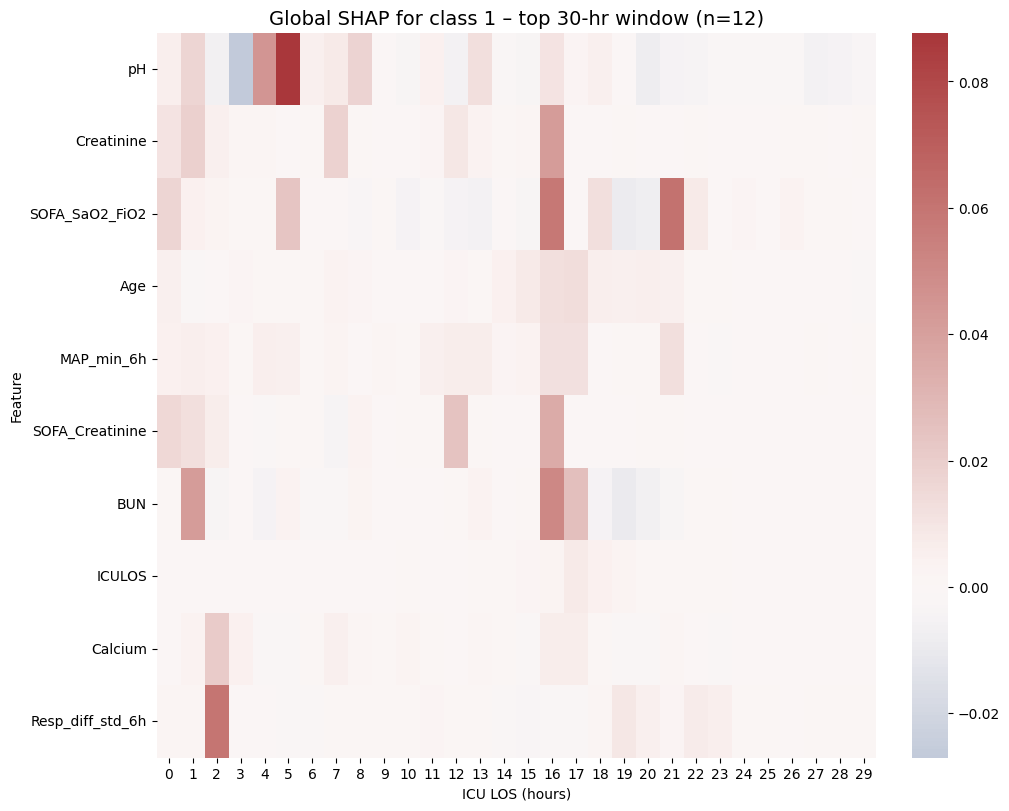

In [56]:
plot, features = global_importance_plot(shap_vals, feature_names, time_index, 1, y_preds, clipping_first=False, clipping_last=True)
plot = global_heatmap(shap_vals, feature_names, time_index, 1, y_preds, features, window_size=30, only_target_relevant=False)

clipping last


/var/folders/s0/ldb10jg949ndmfwfkbsz5x480000gn/T/ipykernel_58790/2714719615.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


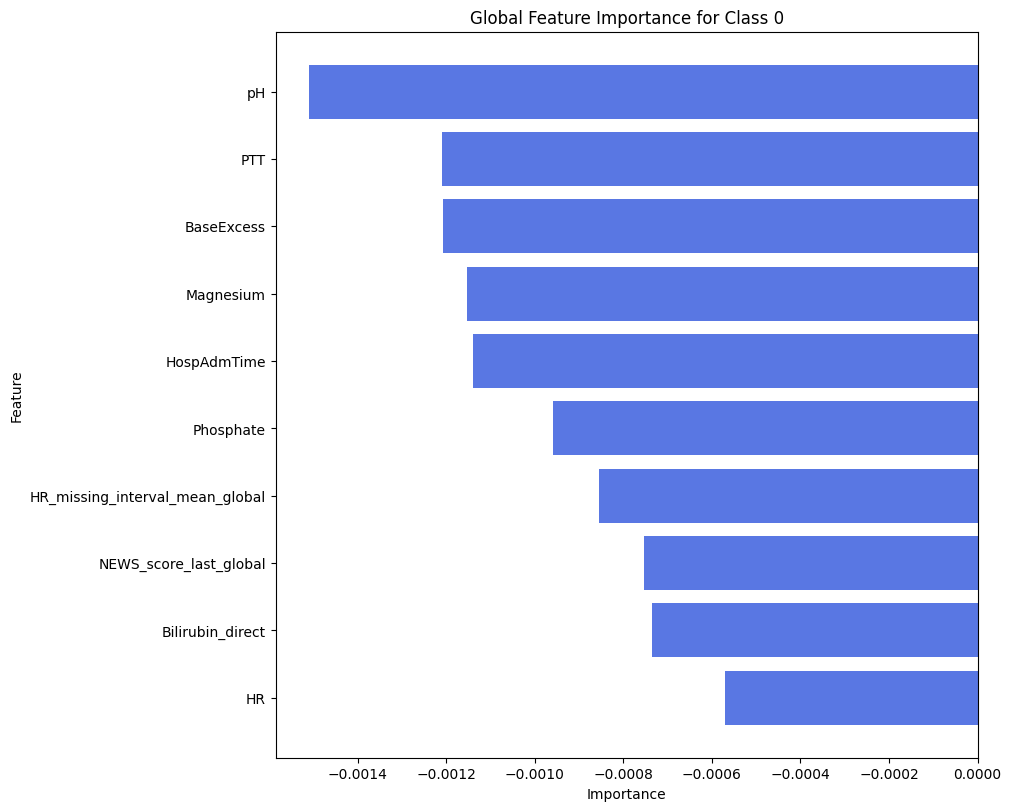

INFO | explain_model_helpers | Using first 30 timesteps (0 – 30)


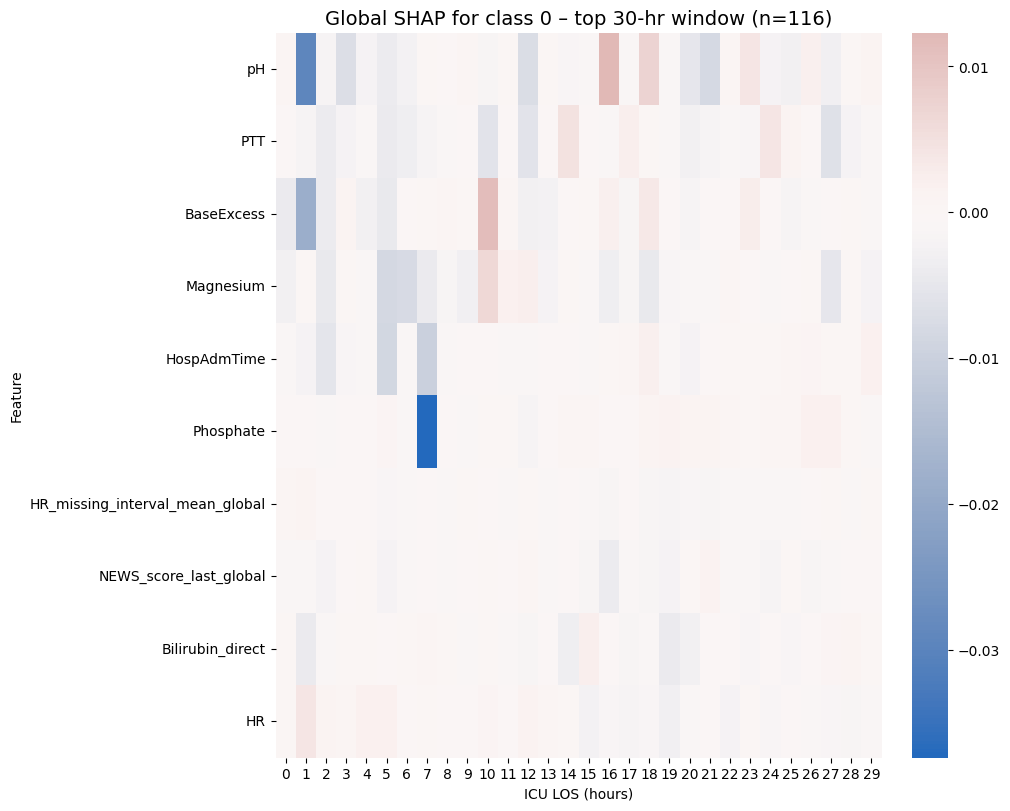

In [55]:
plot, features = global_importance_plot(shap_vals, feature_names, time_index, 0, y_preds, clipping_first=False, clipping_last=True)
plot = global_heatmap(shap_vals, feature_names, time_index, 0, y_preds, features, window_size=30, only_target_relevant=False)